In [23]:
# Importações

import pandas as pd
import joblib


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    QuantileTransformer,
    PolynomialFeatures,
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


import re


from src.config import CLEANED_PATH, FINAL_MODEL
from src.graphics import compareMetrics, plotCoeffs, plotResiduals, plotResidualsFromEstimator
from src.models import trainAndValidate, gridSearch
from src.utils import organizeResults, getCoeffsDataframe

In [24]:
# Obtendo os dados limpos
df = pd.read_parquet(CLEANED_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_households,population_per_households,bedrooms_per_rooms,median_income_cat,housing_median_age_cat
0,-122.25,37.849998,52,1274,235,558,219,5.6431,341300,NEAR BAY,5.817352,2.547945,0.184458,4,4
1,-122.25,37.849998,52,1627,280,565,259,3.8462,342200,NEAR BAY,6.281853,2.181467,0.172096,3,4
2,-122.25,37.849998,52,919,213,413,193,4.0368,269700,NEAR BAY,4.761658,2.139896,0.231774,3,4
3,-122.25,37.840000,52,2535,489,1094,514,3.6591,299200,NEAR BAY,4.931907,2.128405,0.192899,3,4
4,-122.25,37.840000,52,3104,687,1157,647,3.1200,241400,NEAR BAY,4.797527,1.788253,0.221327,3,4


In [25]:
# Resumo da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   longitude                  17340 non-null  float32
 1   latitude                   17340 non-null  float32
 2   housing_median_age         17340 non-null  int8   
 3   total_rooms                17340 non-null  int16  
 4   total_bedrooms             17340 non-null  int16  
 5   population                 17340 non-null  int16  
 6   households                 17340 non-null  int16  
 7   median_income              17340 non-null  float32
 8   median_house_value         17340 non-null  int32  
 9   ocean_proximity            17340 non-null  object 
 10  rooms_per_households       17340 non-null  float64
 11  population_per_households  17340 non-null  float64
 12  bedrooms_per_rooms         17340 non-null  float64
 13  median_income_cat          17340 non-null  int

In [26]:
# Definição das colunas de cada transformação

target_column = ["median_house_value"]

ordinal_columns = ["median_income_cat", "housing_median_age_cat"]

one_hot_columns = ["ocean_proximity"]

robust_scaler_columns = df.columns.difference(
    target_column + one_hot_columns + ordinal_columns
    )

In [27]:
# Definição dos preprocessamentos

pipeline_robust = Pipeline(
    [
        ("poly", PolynomialFeatures(
            degree=1,
            include_bias=False
            )
        ),
        ("robust", RobustScaler())
    ]
)

preprocessing = ColumnTransformer(
    [
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), ordinal_columns),
        ("one_hot", OneHotEncoder(drop="first"), one_hot_columns),
        ("robust_poly", pipeline_robust, robust_scaler_columns)
    ],
)

In [28]:
# Separação das features e do target
X = df.drop(target_column, axis=1)
y = df[target_column[0]]

In [29]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Definindo a grade de parametros

param_grid = {
    "regressor__preprocessing__robust_poly__poly__degree": [1, 2, 3],
    "regressor__regressor__alpha": [1e-2, 5e-2, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50],
}

In [31]:
# Definição do grid search

grid_search = gridSearch(
    regressor=Ridge(),
    preprocessing=preprocessing,
    target_transform=QuantileTransformer(
        n_quantiles=1_000, 
        output_distribution="normal"
        ),
    param_grid=param_grid
)

grid_search

,estimator,TransformedTa...ion='normal'))
,param_grid,"{'regressor__preprocessi...bust_poly__poly__degree': [1, 2, ...], 'regressor__regressor__alpha': [0.01, 0.05, ...]}"
,scoring,"['neg_root_mean_squared_error', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal_encoder', ...), ('one_hot', ...), ...]"


In [32]:
# Ajuste dos pesos
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.01; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.01; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.01; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.01; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.01; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.05; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.05; total time=   0.1s
[CV] END regressor__preprocessing__robust_poly__poly__degree=1, regressor__regressor__alpha=0.05; total time=   0.1s
[C

,estimator,TransformedTa...ion='normal'))
,param_grid,"{'regressor__preprocessi...bust_poly__poly__degree': [1, 2, ...], 'regressor__regressor__alpha': [0.01, 0.05, ...]}"
,scoring,"['neg_root_mean_squared_error', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal_encoder', ...), ('one_hot', ...), ...]"


In [33]:
# Melhores parametros
grid_search.best_params_

{'regressor__preprocessing__robust_poly__poly__degree': 3,
 'regressor__regressor__alpha': 0.01}

In [34]:
# Estimador com melhores parametros
grid_search.best_estimator_

,regressor,Pipeline(step...alpha=0.01))])
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('ordinal_encoder', ...), ('one_hot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [35]:
# Coeficientes das features

df_coeffs = getCoeffsDataframe(
    grid_search.best_estimator_.regressor_["regressor"].coef_,
    grid_search.best_estimator_.regressor_["preprocessing"].get_feature_names_out(),
)
df_coeffs

,coeficientes
robust_poly__housing_median_age longitude median_income,-9.948369
robust_poly__median_income,-9.666148
robust_poly__latitude population_per_households,-9.400088
robust_poly__median_income population_per_households total_bedrooms,-7.004509
robust_poly__bedrooms_per_rooms longitude median_income,-6.917393
...,...
robust_poly__bedrooms_per_rooms housing_median_age total_rooms,6.492306
robust_poly__housing_median_age total_bedrooms,6.492306
robust_poly__bedrooms_per_rooms longitude total_bedrooms,6.716627
robust_poly__bedrooms_per_rooms^2 latitude,7.468363


In [36]:
# Verificando se algum coeficiente foi zerado
df_coeffs[df_coeffs["coeficientes"] == 0]

,coeficientes


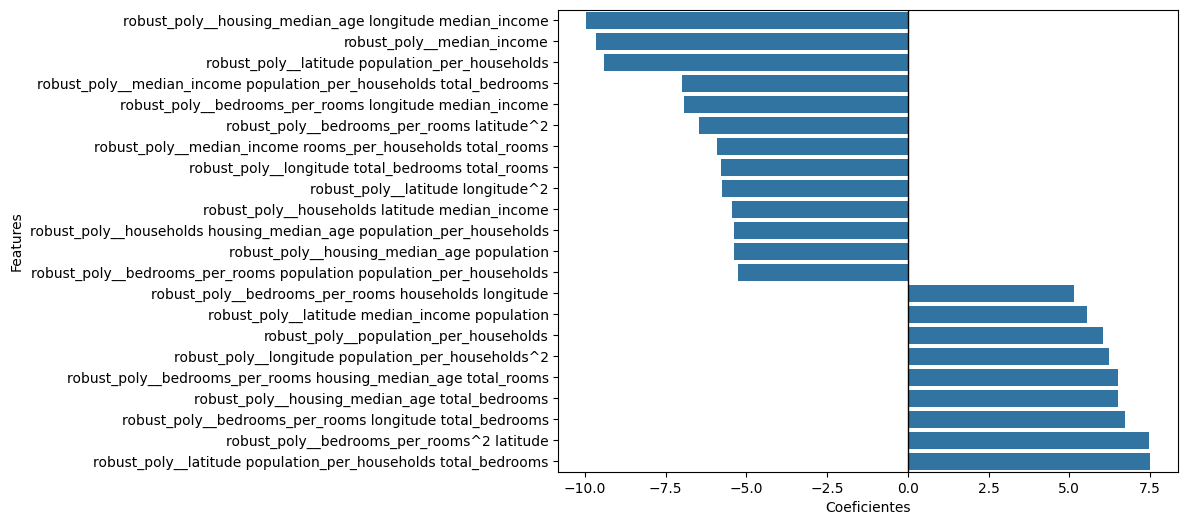

In [37]:
# Gerando gráfico desses coeficientes
plotCoeffs(
    df_coeffs[~df_coeffs["coeficientes"].between(
        -5, 5
        )]
    )

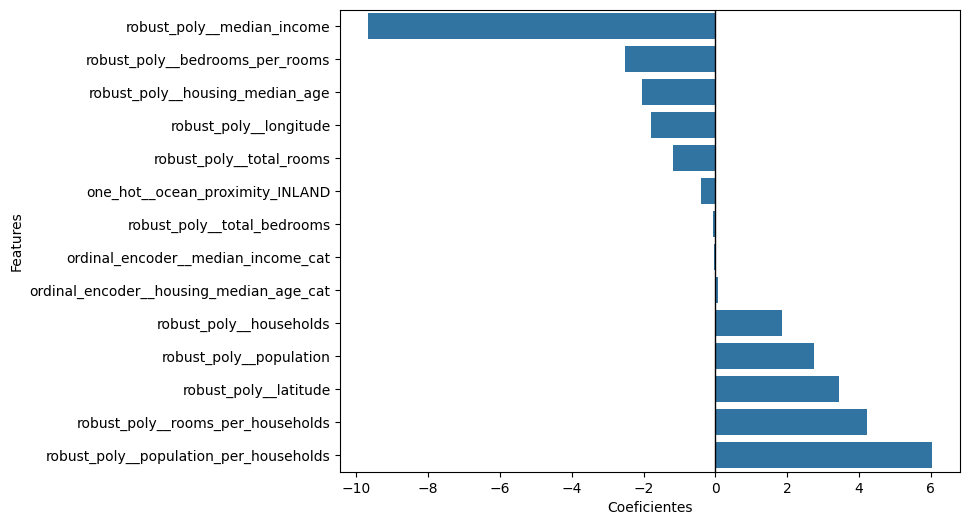

In [38]:
# Gerando gráfico desses coeficientes dos parametros lineares
non_linear_pattern = re.compile(r"\^[2-9]")

linear_parameters = df_coeffs.index[
    ~(df_coeffs.index.str.contains(" ")) & 
    ~(df_coeffs.index.str.contains(non_linear_pattern))
    ]

plotCoeffs(
    df_coeffs.loc[linear_parameters]
    )

In [39]:
# Definição dos regressores, com ou sem preprocessamentos nas coluna e/ou transformação no target

regressors = {
    "DummyRegressor": {
        "preprocessing": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transform": None,
    },
    "LinearRegression": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": None,
    },
    "LinearRegression_target": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": QuantileTransformer(
            n_quantiles=1_000,
            output_distribution="normal"
        ),
    },
    "Ridge_grid_search": {
        "preprocessing": grid_search.best_estimator_.regressor_["preprocessing"],
        "regressor": grid_search.best_estimator_.regressor_["regressor"],
        "target_transform": grid_search.best_estimator_.transformer_,
    },
}

# Obtendo os resultados de cada regressor

results = {
    name: trainAndValidate(X, y, **regressor) for name, regressor in regressors.items()
}

df_results = organizeResults(results)
df_results

,model,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
0,DummyRegressor,-74496.622,-91828.212064,-0.000031,0.008809
1,DummyRegressor,-74033.8009,-90953.345064,-0.000072,0.007607
2,DummyRegressor,-73436.810725,-91261.635258,-0.000214,0.005248
3,DummyRegressor,-75005.696104,-92007.342962,-0.000095,0.007426
4,DummyRegressor,-74476.318859,-91827.966753,-0.000058,0.003769
5,LinearRegression,-40461.156491,-53585.381591,0.659471,0.075135
6,LinearRegression,-40497.930626,-53229.728607,0.657467,0.073617
7,LinearRegression,-40657.91515,-54061.914203,0.649006,0.065358
8,LinearRegression,-39544.196294,-53556.524508,0.661139,0.060021
9,LinearRegression,-39999.623133,-53140.949033,0.665085,0.057105


In [40]:
# Agrupando a mediana das métricas de cada modelo
df_results.groupby("model").median()

,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
model,,,,
DummyRegressor,-74476.318859,-91827.966753,-0.000072,0.007426
LinearRegression,-40461.156491,-53556.524508,0.659471,0.065358
LinearRegression_target,-38389.968796,-52558.570651,0.670582,0.06405
Ridge_grid_search,-34977.563578,-49004.880712,0.712244,0.958947


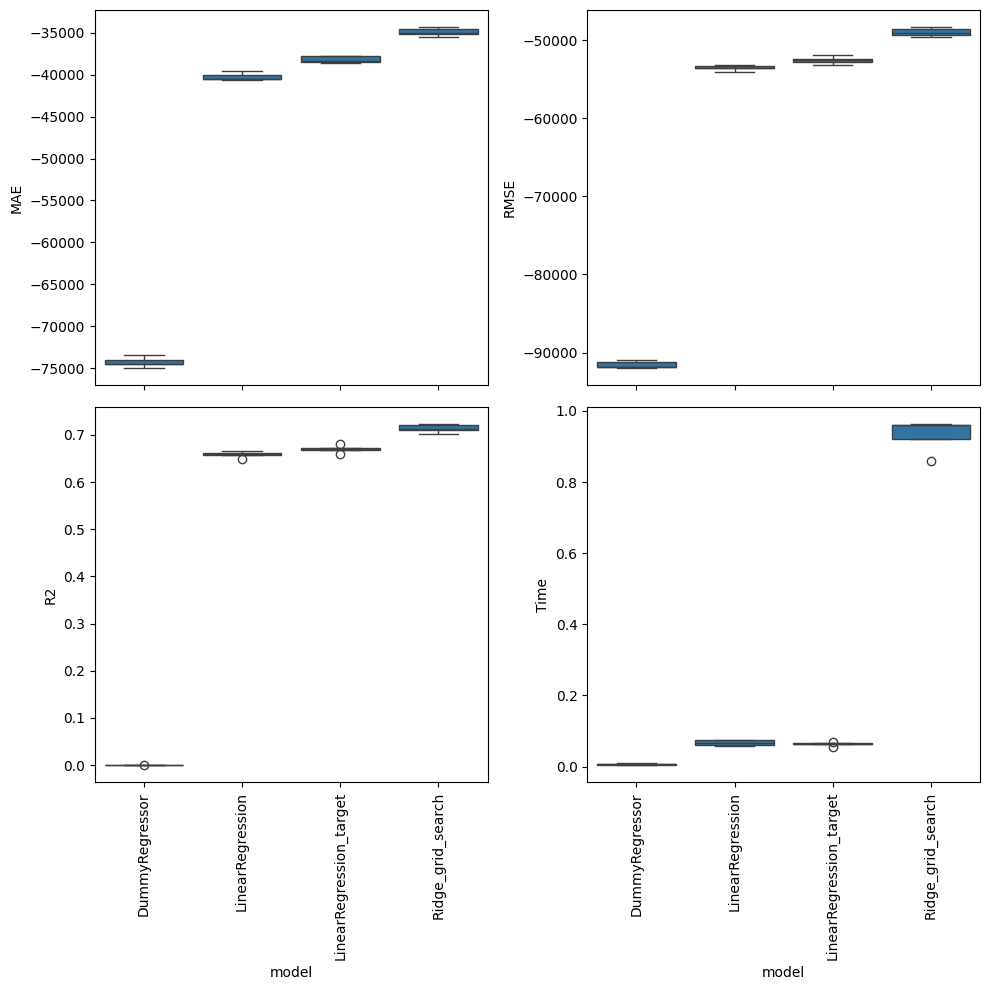

In [41]:
# Comparação das métricas de cada modelo
compareMetrics(df_results, ["MAE", "RMSE", "R2", "Time"])

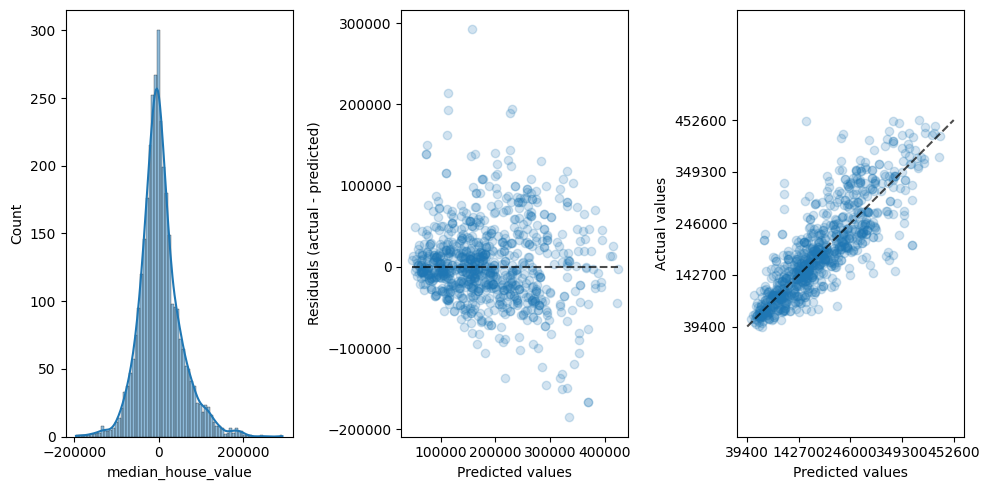

In [42]:
# Gráficos de residuos

y_pred = grid_search.best_estimator_.predict(X_test)

plotResiduals(y_test, y_pred)

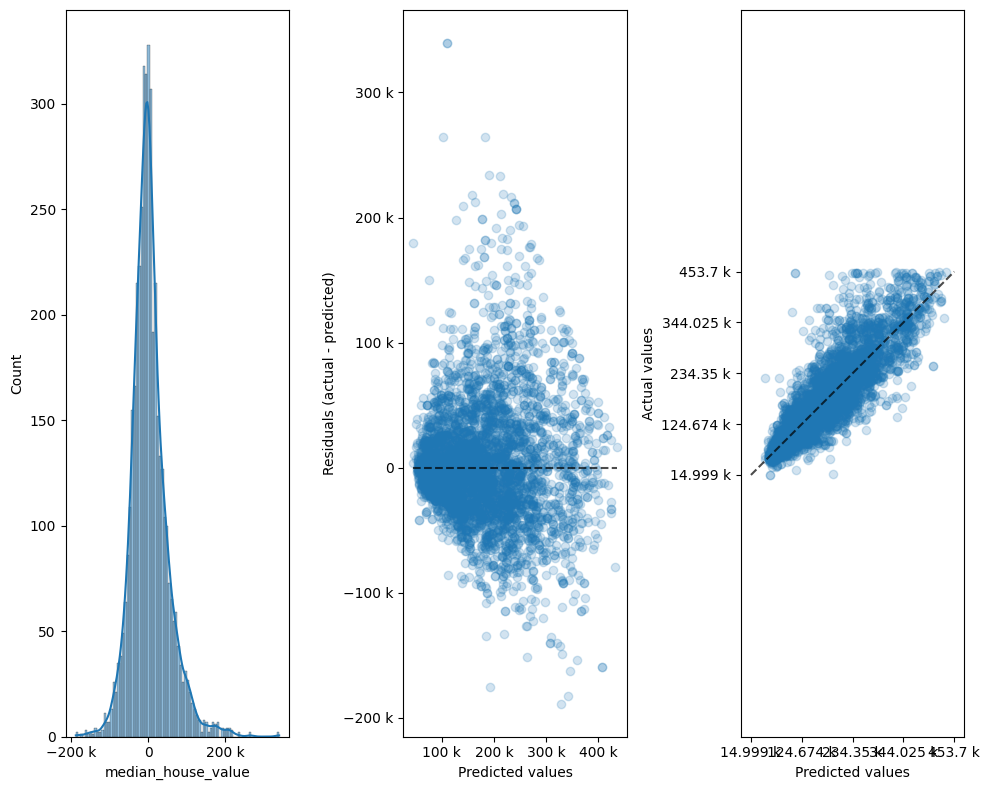

In [43]:
plotResidualsFromEstimator(grid_search.best_estimator_, X, y, eng_formatter=True)

In [44]:
# Salvando o modelo
joblib.dump(
    grid_search.best_estimator_, 
    FINAL_MODEL
    )

['/home/lucas/Documentos/python/california_median_price_value/models/ridge_polyfeat_target_quantile.joblib']